In [17]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_clean = pd.read_csv('../data/clean.csv')

# Random Forest Classification Model (all selected features)

In [18]:
df_clean['classification'].value_counts()

classification
1    161
0    132
Name: count, dtype: int64

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

X = df_clean[['hemo', 'sc', 'htn', 'dm', 'bp', 'bgr', 'age']]
y = df_clean['classification']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 18,
    stratify = y
)

**Note: See logistic regression notebook for Train-test-split annotations**

In [20]:
model = RandomForestClassifier(
    random_state = 18,
    max_depth = 3,
    min_samples_split= 5,     
    min_samples_leaf = 2,      
    max_features = 'sqrt',
    criterion = 'entropy'
)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'entropy'
,max_depth,3
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


**Random Forest Classifiers are known to be extremely efficient at small datasets, being able to produce high accuracy (often due to overfitting easily), so restrictions on max_depth, min_samples_split, min_samples_leaf, and max_features were implemented as a way to penalize training data memorization. The entropy criterion was chosen over Gini (default) since it considers other features (in addition to top indicators) slightly more.**

In [21]:
y_predict = model.predict(X_test)

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        27
           1       1.00      0.97      0.98        32

    accuracy                           0.98        59
   macro avg       0.98      0.98      0.98        59
weighted avg       0.98      0.98      0.98        59



In [22]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
print("Accuracy per Fold:", scores)
print("Mean accuracy:", np.mean(scores))

Accuracy per Fold: [1.         1.         1.         1.         0.93103448 1.
 1.         1.         1.         1.        ]
Mean accuracy: 0.993103448275862


**Even with very conservative hyperparameters, the classifier can separate the data almost every time perfectly (9 out of 10 folds). This raises some eyebrows but is explored in detail in sections below and graphically in the SVM notebook. In short, the small dataset (~300 samples) and the strong indicators (hemo + sc) make a model like random forest extremely effective, but suggest it may not generalize well.**

# Feature Importance

In [23]:
features = pd.DataFrame({
    'Features': X.columns,
    'AbsCoeff': model.feature_importances_
})
features = features.sort_values(by='AbsCoeff', ascending=False)
features

,Features,AbsCoeff
0,hemo,0.343812
1,sc,0.298535
2,htn,0.143772
3,dm,0.096534
5,bgr,0.071056
4,bp,0.027473
6,age,0.018818


**The Feature importance coefficients align with the earlier suspicions; it seems as though the model weighs hemo and sc extremely highly, making it able to separate the data with minimal consideration for other features. External validation will be needed (and a more diverse and larger dataset) to fully utilize random forest classifiers. In the future, models like XGBoost and GradientBoost are also options with bigger data, but currenetly provide no real value since even a conservative random forest is able to max out this dataset.**

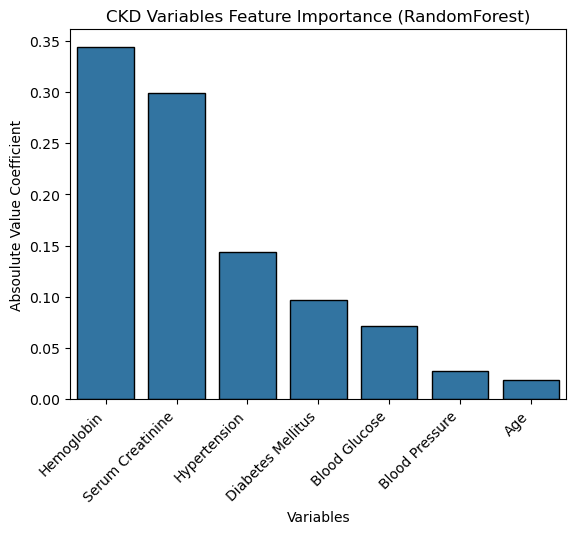

In [24]:
sns.barplot(
    data = features,
    x = 'Features',
    y = 'AbsCoeff',
    capsize=0.2,
    edgecolor='black'
)
plt.title('CKD Variables Feature Importance (RandomForest)')
plt.xlabel('Variables')
plt.ylabel('Absoulute Value Coefficient')
plt.xticks(['htn', 'sc', 'hemo', 'bp', 'age', 'bgr', 'dm'], ["Hypertension", "Serum Creatinine", "Hemoglobin", "Blood Pressure", "Age", "Blood Glucose", "Diabetes Mellitus"])
plt.xticks(rotation=45, ha="right")
plt.savefig("../figures/feature_importance/RandomForest_Feature_Importance.png", dpi=300, bbox_inches='tight')
plt.show()

# ROC Curve & AUC Score

In [10]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"AUC Score: {round(roc_auc, 4)}")

AUC Score: 1.0


**As explained above, the dataset is largely the issue here, since the random forest is easily able to separate a small dataset with strong indicators. The extremely high metrics suggest that random forest is not going to provide too much information in this case (due to overfitting and lack of generalizability), other than the fact that the data is extremely separable. It remains a top choice in the future, when a higher magnitude and diversity of datapoints are utilized.**

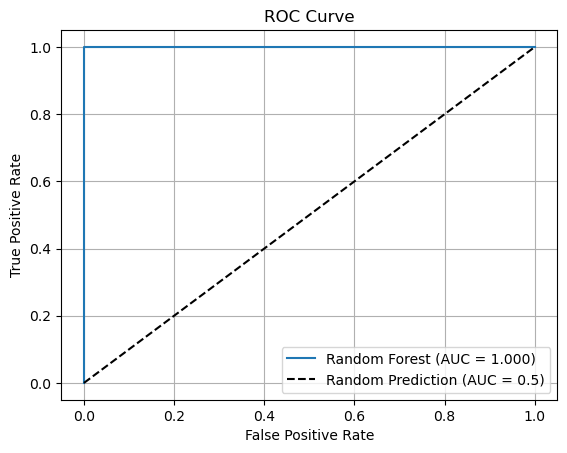

In [25]:
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Prediction (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.savefig("../figures/roc_auc/RandomForest_ROC.png", dpi=300, bbox_inches='tight')
plt.show()

# Calibration Curve 

**See logistic regression notebook for calibration curve annotations.**

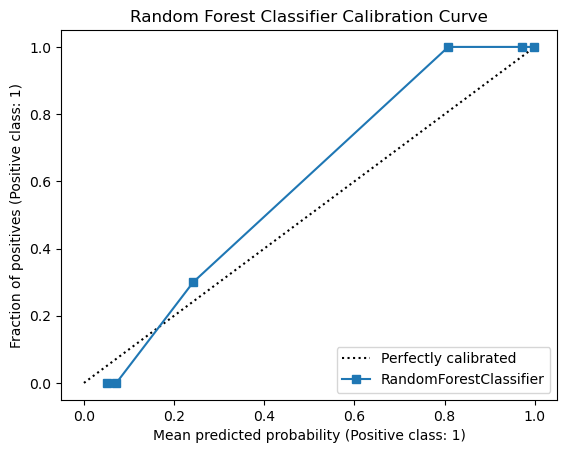

In [26]:
from sklearn.calibration import CalibrationDisplay

CalibrationDisplay.from_estimator(
    model,
    X_test,
    y_test,
    n_bins = 6,
    strategy = 'quantile'
)
plt.title("Random Forest Classifier Calibration Curve")
plt.savefig("../figures/calibration/CalibrationCurve(RandomForest).png", dpi=300, bbox_inches='tight')
plt.show()